In [1]:
%load_ext autoreload 
%autoreload 2

In [2]:
import json
from privacypacking.utils.utils import load_logs, global_metrics
import pandas as pd
from experiments.ray.analysis import load_ray_experiment, load_latest_ray_experiment, load_latest_scheduling_results, load_latest_scheduling_results
import plotly.express as px
from privacypacking.budget.curves import  LaplaceCurve, GaussianCurve, SubsampledGaussianCurve
from privacypacking.budget import Budget, Task, Block
from privacypacking.schedulers.metrics import OverflowRelevance, FlatRelevance
from privacypacking.budget.block_selection import RandomBlocks
from privacypacking.utils.plot import plot_budgets
import yaml
from pathlib import Path
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import numpy as np

In [44]:
df = load_latest_scheduling_results(alphas=True)

/home/pierre/privacypacking/logs/exp_1118-144249/time_based_budget_unlocking_DominantShares/1118-144254_ddd0f8.json
/home/pierre/privacypacking/logs/exp_1118-144249/time_based_budget_unlocking_BatchOverflowRelevance/1118-144253_fce1da.json
/home/pierre/privacypacking/logs/exp_1118-144249/time_based_budget_unlocking_DynamicFlatRelevance/1118-144254_940b45.json
/home/pierre/privacypacking/logs/exp_1118-144249/time_based_budget_unlocking_FlatRelevance/1118-144254_049600.json
/home/pierre/privacypacking/logs/exp_1118-144249/time_based_budget_unlocking_Fcfs/1118-144254_7967dd.json


In [45]:
maxeps = {}
for task_file in Path("/home/pierre/privacypacking/data/mixed_curves_large/tasks").glob("*.yaml"):
    task_dict = yaml.safe_load(task_file.open("r"))
    maxeps[f"{task_dict['rdp_epsilons'][-1]:.3f}"]=task_file.stem
maxeps

{'34.083': 'gaussian_5.0',
 '12.270': 'gaussian_3.0',
 '1.989': 'laplace_2.0',
 '5.453': 'gaussian_2.0',
 '1611676.972': 'subsampled_gaussian_5.0',
 '2.989': 'laplace_3.0',
 '679315.804': 'subsampled_gaussian_2.0',
 '3.989': 'laplace_4.0',
 '1085676.505': 'subsampled_gaussian_3.0',
 '4.989': 'laplace_5.0',
 '1385079.754': 'subsampled_gaussian_4.0',
 '21.813': 'gaussian_4.0'}

In [46]:
def get_task_name(s):
    n,m = s.split("-")
    return f"{n}-{maxeps[m]}"

In [47]:
df["task"] = df["nblocks_maxeps"].apply(get_task_name)

In [48]:
grouped = df[["id","task","allocated","metric"]].drop_duplicates(subset=['id', 'metric']).groupby(["task","metric"]).agg([np.sum, "count"])
grouped = grouped.reset_index()
grouped["n_allocated"] = grouped["allocated"]["sum"]
grouped["total"] = grouped["allocated"]["count"]
grouped = grouped.drop(["id", "allocated"], axis=1)
grouped["n_rejected"] = grouped["total"] - grouped["n_allocated"]
# grouped

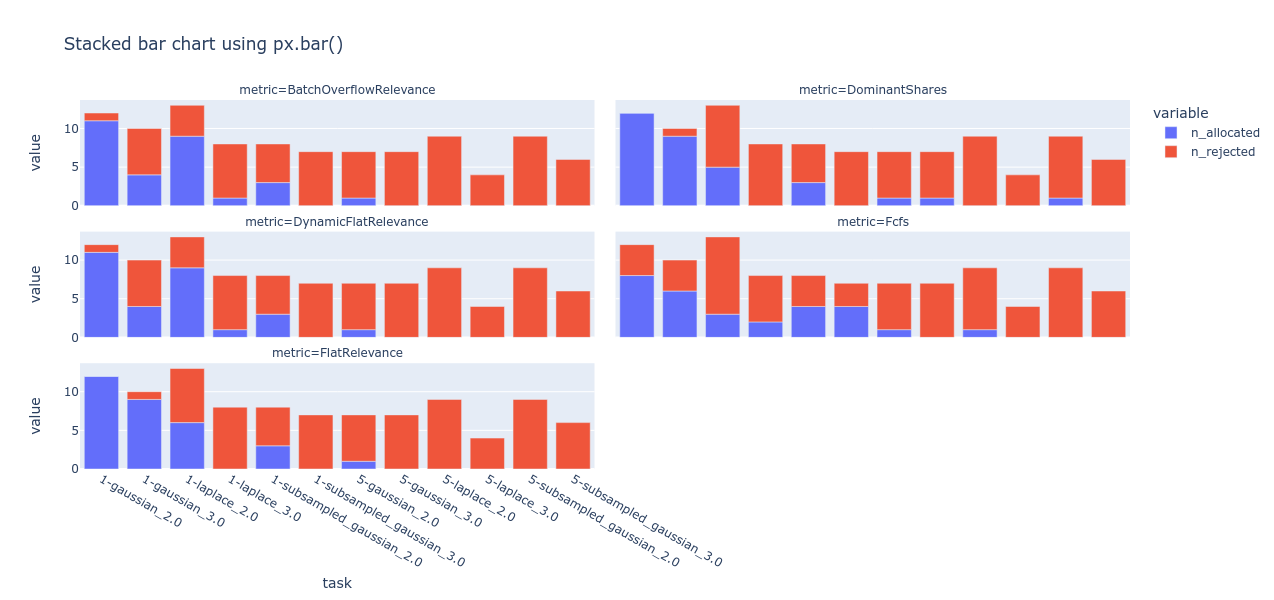

In [52]:
px.bar(grouped, 
         x = "task",
         y = ["n_allocated", "n_rejected"],
         title = 'Stacked bar chart using px.bar()', 
        facet_col="metric",
            facet_col_wrap=2,
            height=600,
             )

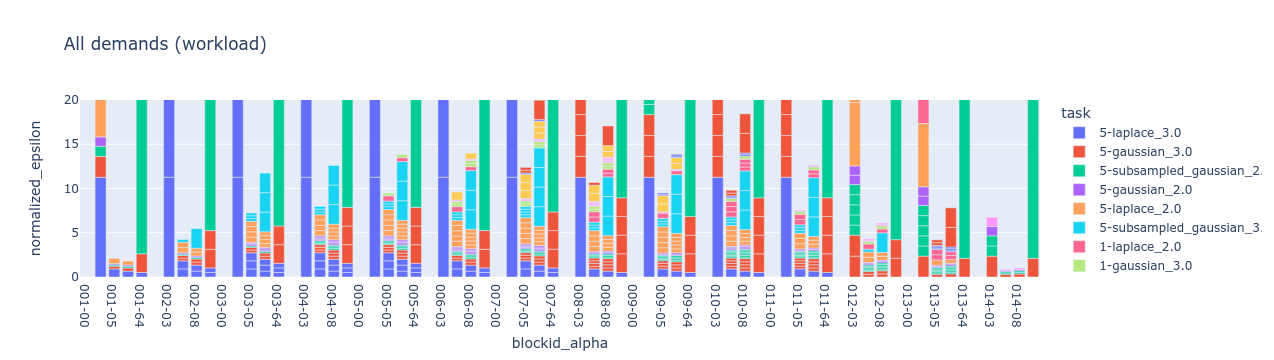

In [50]:
px.bar(
    # df,
    df.query("metric == 'DominantShares'"),
    x="blockid_alpha",
    y="normalized_epsilon",
    range_y=[0,20],
#     color="log_id",
    color="task",
    # barmode="group",
    # pattern_shape="allocated",
    # facet_col="metric",
    # facet_col_wrap=1,
    height=300,
    title="All demands (workload)"
#     animation_frame="id"
)

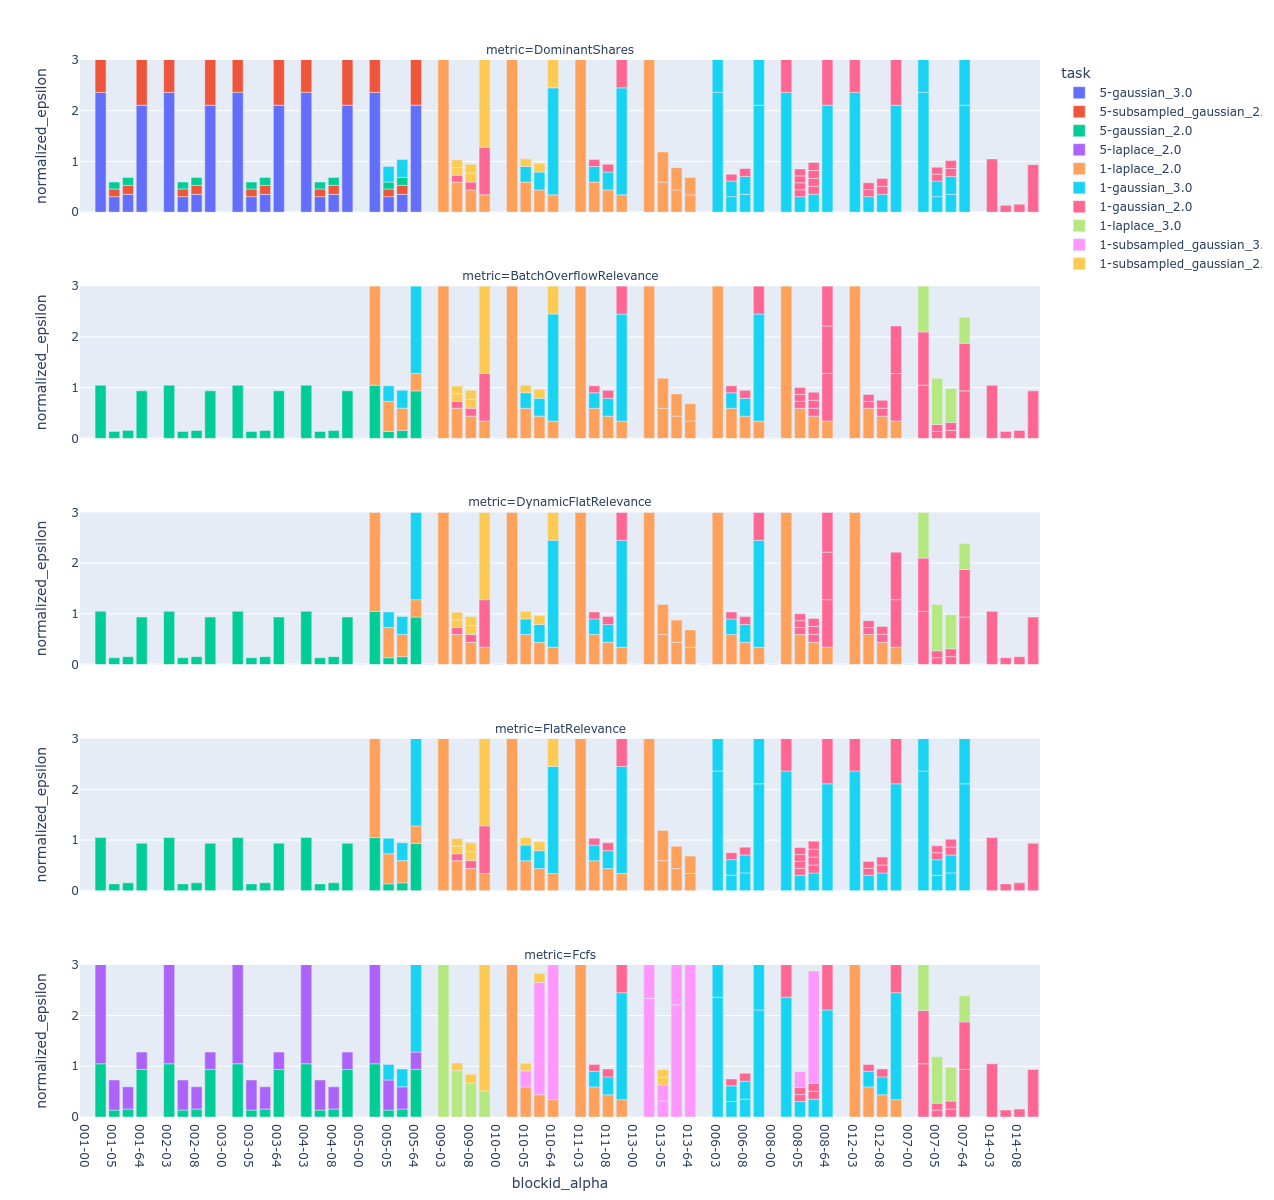

In [51]:
px.bar(
    # df,
    df.query("allocated"),
    x="blockid_alpha",
    y="normalized_epsilon",
    range_y=[0,3],
#     color="log_id",
    color="task",
    # barmode="group",
    # pattern_shape="allocated",
    facet_col="metric",
    facet_col_wrap=1,
    height=1200,
#     animation_frame="id"
)